# Bayesian inference with priors: from parallax to distance

In this tutorial, we will explore how astronomers use parallax to measure distances to stars and apply Bayesian inference to improve distance estimates when there is uncertainty in the measurements. We'll introduce log-likelihoods, log-priors, and log-posteriors, and show how these concepts can help us account for uncertainties and apply different beliefs (priors) about the star's distance.

In [12]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches

# Make the size and fonts larger for this presentation
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2

### 1. **What is Parallax?**

Parallax is the apparent shift in the position of an object when observed from different positions. In astronomy, we measure the angle by which a star seems to shift when viewed from different points in Earth's orbit. This shift, known as the **parallax angle**, allows us to calculate the distance to a star.

- **Parallax Angle (`parallax`)**: The angular shift measured in arcseconds.
- **Distance (`distance`)**: The distance to the star, calculated as:

$$
D_\varpi = distance = \frac{1}{parallax} \cdot \frac{1\,\mathrm{pc}}{1\,\mathrm{arcsec}} = \frac{1}{\varpi}  \cdot \frac{1\,\mathrm{pc}}{1\,\mathrm{arcsec}}
$$

If the parallax angle of a star is 0.1 arcseconds, the distance to the star is:

$$
D_\varpi = \frac{1}{0.1\,\mathrm{arcsec}} \cdot \frac{1\,\mathrm{pc}}{1\,\mathrm{arcsec}} = 10 \text{ parsecs}
$$

### 2. **Dealing with Uncertainty**

Real measurements are never perfect. There's always uncertainty in the measured parallax angle, which introduces uncertainty into the distance calculation. Instead of a single value for the distance, we infer a **range of possible distances** based on the observed parallax and the uncertainty (standard deviation).

- **Uncertainty in `parallax`**: Parallax measurements come with a standard deviation, `sigma_parallax`, which represents the measurement error.

### 3. **Bayesian Inference: Likelihood, Priors, and Posteriors**

Bayesian inference is a statistical approach that allows us to incorporate prior knowledge about a parameter (in this case, the star’s distance) along with the observed data (parallax measurement). The goal is to compute the **posterior distribution**, which combines the likelihood of the observed data with the prior beliefs.

#### a. **Likelihood**:
The likelihood represents the probability of observing the data (`parallax`, parallax measurement $\varpi$) given a true distance $D_\varpi$ (`distance`). For parallax measurements, we assume a normal distribution for the likelihood:

$$
\text{Likelihood: } P(\varpi | D_\varpi) \sim \mathcal{N} \left(\frac{1}{D_\varpi}, \sigma_\varpi \right)
$$

The **log-likelihood** is often more convenient to work with, especially when combining many terms. The log-likelihood for a normal distribution is:

$$
\ln P(\varpi | D_\varpi) = -\frac{1}{2} \frac{(\varpi - \frac{1}{D_\varpi})^2}{\sigma_\varpi^2} - \frac{1}{2} \ln(2 \pi \sigma_\varpi^2)
$$

#### b. **Priors**:
A prior reflects our belief about the distribution of `distance` before taking into account the data. We may have different priors:
- **Uniform Prior**: We assume the star is equally likely to be at any distance up to some maximum distance, `distance_max` $D_\text{max}$.

$$
P(D_\varpi) = \frac{1}{D_{\text{max}}}, \quad \text{for } 0 < D_\varpi < D_{\text{max}}
$$

- **Log-Prior**:
$$
\ln P(D_\varpi) = \ln \left( \frac{1}{D_\text{max}} \right), \quad \text{for } 0 < D_\varpi < D_{\text{max}}
$$

#### c. **Posterior**:
The posterior combines the likelihood and prior to provide a new distribution, giving the probability of the true distance (`distance`) given the parallax measurement (`parallax`):

$$
\text{Posterior: } P(D_\varpi | \varpi) \propto P(\varpi | D_\varpi) \cdot P(D_\varpi)
$$

And in log form:
$$
\ln P(D_\varpi | \varpi) = \ln P(\varpi | D_\varpi) + \ln P(D_\varpi)
$$

#### b. **Why logarithmic forms?**

- **Preventing Underflow (Handling Very Small Numbers):** When dealing with probabilities, especially in large datasets, the values of the likelihood and posterior probabilities can become very small (close to zero).  
- **Simplifying Multiplications:** Addition is computationally easier and more efficient than multiplication, especially when dealing with many data points or large datasets.  
- **Numerical Stability:** When working with very small or very large numbers (which are common in likelihood and posterior calculations), rounding errors can accumulate, leading to inaccuracies.  
- **Better Optimization:** Gradient-based optimization algorithms (like those used in machine learning and statistics) often perform better with sums (logarithmic values) rather than products, which can lead to more efficient and stable convergence.  
- **Logarithms are easier to work with in Probabilistic Modeling:** In many probabilistic models, particularly those that involve normal distributions or other exponential family distributions, the log-likelihood often takes a very convenient form. For instance, the log-likelihood of a normal distribution is quadratic in the parameters, which is easier to work with mathematically:
$$
\ln P(x | \mu, \sigma) = - \frac{(x - \mu)^2}{2\sigma^2} - \frac{1}{2} \ln(2 \pi \sigma^2)
$$

### 4. **Implementing the Parallax Model in Python**

We'll now implement this step-by-step in Python using `matplotlib` and `scipy.stats` for the likelihood and prior functions, but this time focusing on **log-likelihoods** and **log-priors**.

#### Define the Log-Likelihood, Log-Prior, and Log-Posterior

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Log-Likelihood function for parallax measurement
def log_likelihood(parallax, distance, sigma_parallax):
    """Log-likelihood for parallax measurement.
    
    Parameters:
    parallax : parallax value
    distance : true distance
    sigma_parallax : standard deviation of parallax error
    
    Returns:
    Log-likelihood of observing w given r and wsd.
    """
    return -0.5 * ((parallax - 1/distance)**2 / sigma_parallax**2) - np.log(sigma_parallax * np.sqrt(2 * np.pi))

# Log-Prior function (uniform between 0 and rmax)
def log_prior(distance, distance_max):
    """Log-uniform prior for distance (r) truncated between 0 and rmax."""
    if distance > 0 and distance < distance_max:
        return -np.log(distance_max)
    else:
        return -np.inf  # log(0) for impossible distances
    
# Log-Posterior function
def log_posterior(parallax, distance, sigma_parallax, distance_max):
    """Log-posterior for parallax measurement combining likelihood and prior."""
    return log_likelihood(parallax, distance, sigma_parallax) + log_prior(distance, distance_max)


#### Create some example case

In [15]:
# Example parallax measurement and uncertainty
parallax = 0.5          # Parallax measurement
sigma_parallax = 0.1    # Parallax uncertainty (standard deviation)

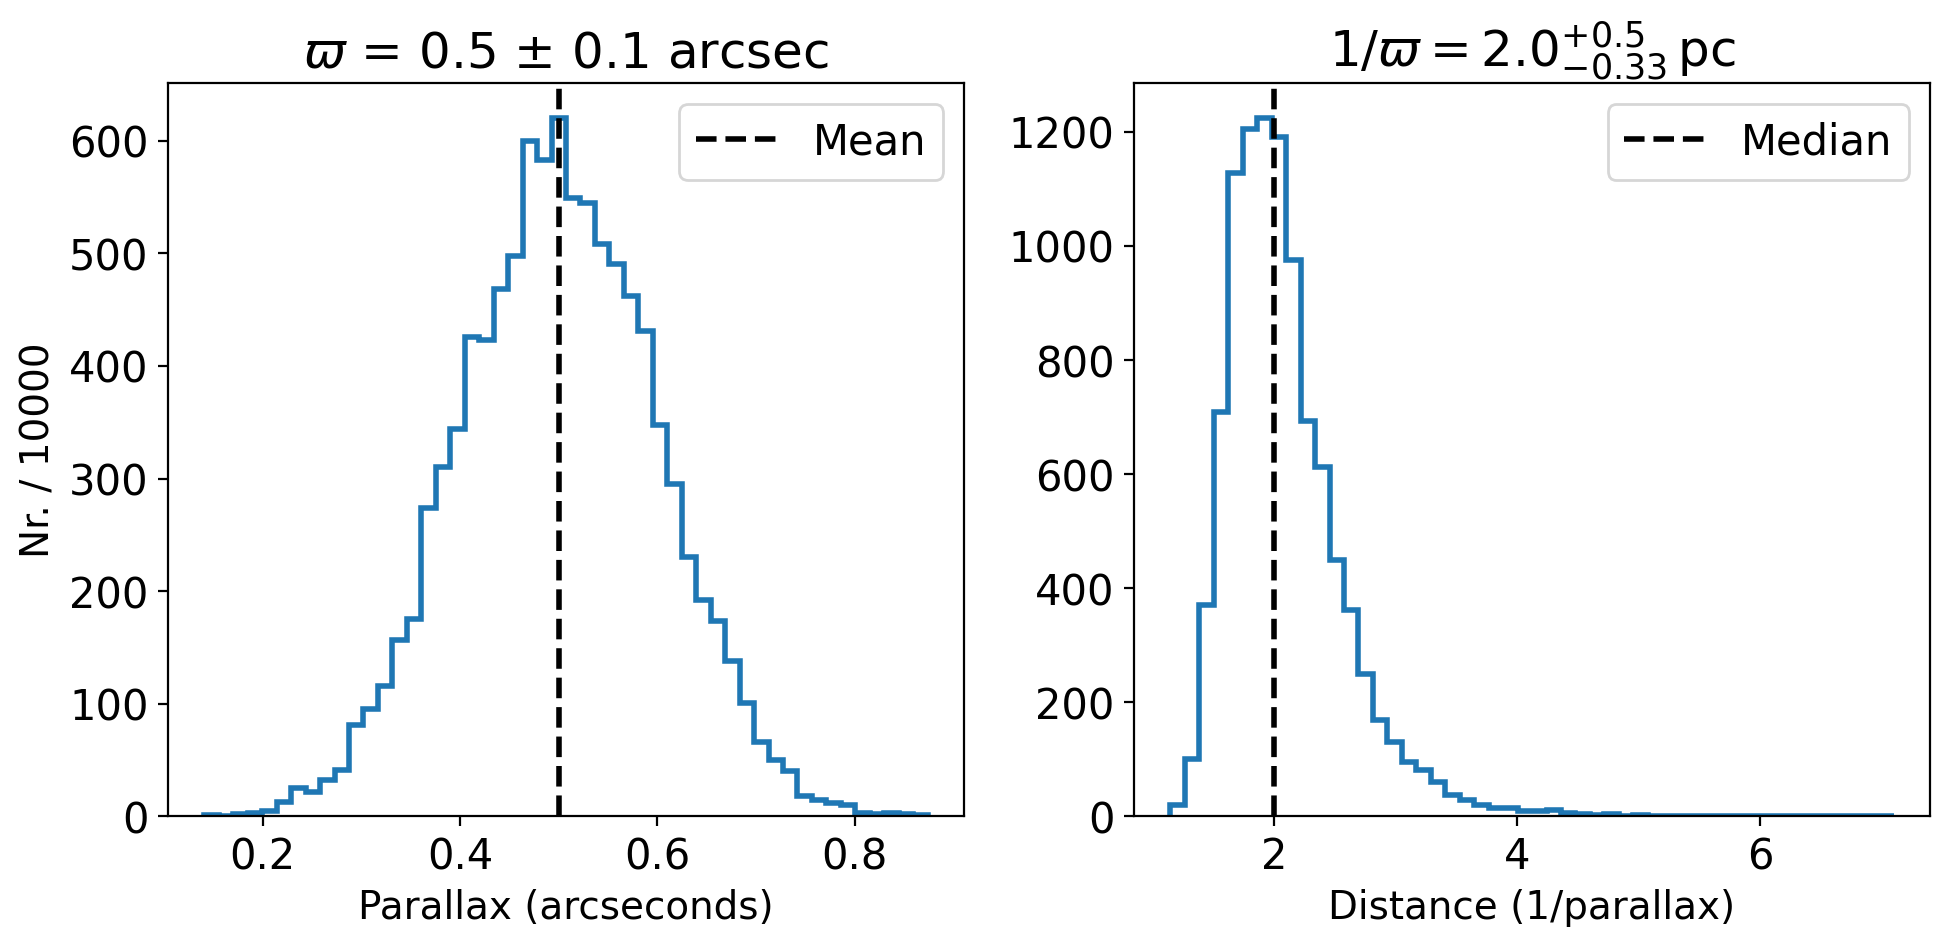

In [16]:
# Generate random parallax values based on the measurement and uncertainty (assumed Gaussian)
n_samples = 10000  # Number of samples to simulate
parallax_samples = np.random.normal(parallax, sigma_parallax, n_samples)

# Calculate distance as 1/parallax, but filter out cases where the parallax is negative
distance_samples = 1 / parallax_samples

distance_percentiles = np.percentile(distance_samples, q=[16,50,84])

# Count how many distances are negative
negative_distances = np.sum(parallax_samples <= 0)

# Calculate the percentage of negative distances
negative_distance_percentage = (negative_distances / n_samples) * 100

# Create a 2-panel plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Panel a: Distribution of parallax values
axes[0].hist(parallax_samples, bins=50, histtype='step', lw=2)
axes[0].axvline(np.mean(parallax_samples), color='k', linestyle='--', label = 'Mean')
axes[0].set_title(r'$\varpi$ = '+f'{parallax} ± {sigma_parallax} arcsec')
axes[0].set_xlabel('Parallax (arcseconds)', fontsize=14)
axes[0].set_ylabel('Nr. / '+str(n_samples), fontsize=14)
axes[0].legend(loc='upper right')

# # Panel b: Distribution of 1/parallax (distances)
axes[1].hist(distance_samples, bins=50, histtype='step',lw=2)

axes[1].set_title(r'$1 / \varpi = '+str(np.round(distance_percentiles[1],2))+'_{-'+str(np.round(distance_percentiles[1]-distance_percentiles[0],2))+'}^{+'+str(np.round(distance_percentiles[2]-distance_percentiles[1],2))+r'}\,\mathrm{pc}$')
axes[1].axvline(distance_percentiles[1], color='k', linestyle='--', label = 'Median')
axes[1].legend(loc='upper right')
axes[1].set_xlabel('Distance (1/parallax)', fontsize=14)
axes[0].set_ylabel('Nr. / '+str(n_samples), fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
# Example parallax measurement and uncertainty
parallax = 0.02  # True parallax -> distance = 50 pc
sigma_parallax = 0.04    # Parallax uncertainty (standard deviation)

# Range of distances
distance_vals = np.linspace(0.1, 500, 1000)

# Compute uniform log-prior (assume max distance is 20 parsecs)
distance_max = 500

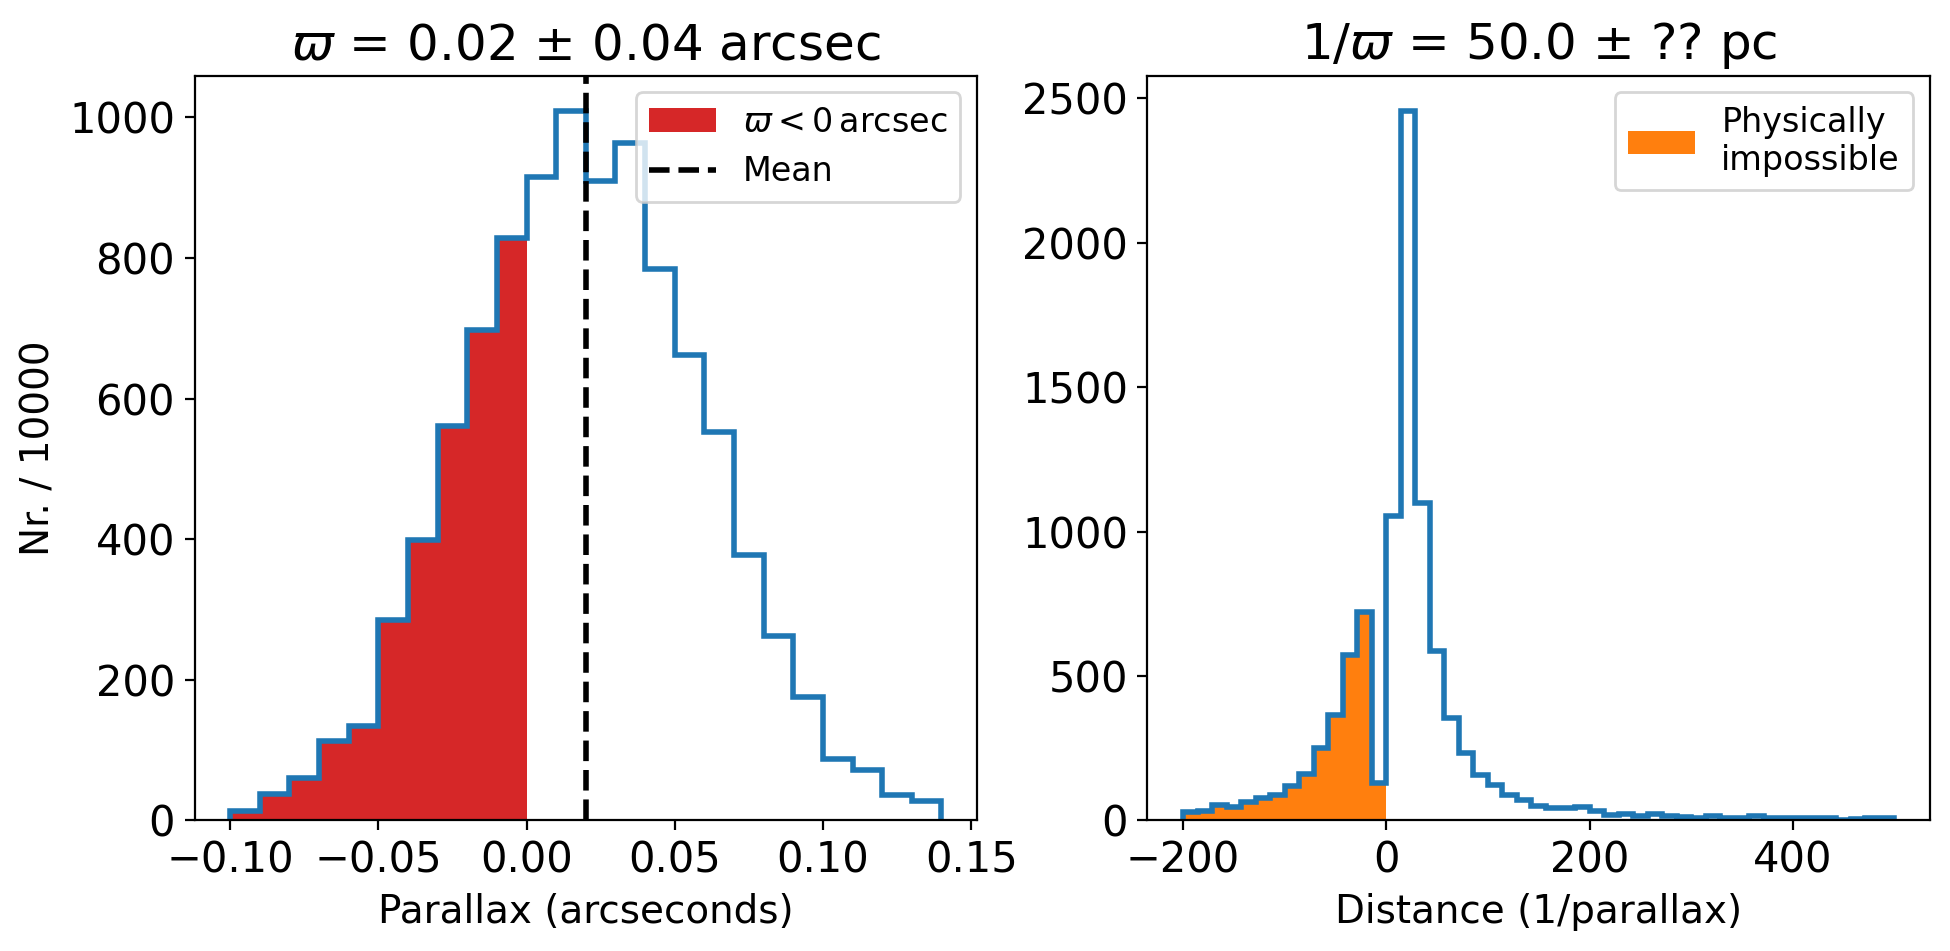

In [18]:
# Generate random parallax values based on the measurement and uncertainty (assumed Gaussian)
n_samples = 10000  # Number of samples to simulate
parallax_samples = np.random.normal(parallax, sigma_parallax, n_samples)

# Calculate distance as 1/parallax, but filter out cases where the parallax is negative
distance_samples = 1 / parallax_samples

# Count how many distances are negative
negative_distances = np.sum(parallax_samples <= 0)

# Calculate the percentage of negative distances
negative_distance_percentage = (negative_distances / n_samples) * 100

# Create a 2-panel plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Panel a: Distribution of parallax values
axes[0].hist(parallax_samples, bins=np.linspace(parallax - 3*sigma_parallax,parallax + 3*sigma_parallax,25), histtype='step', lw=2)
axes[0].hist(parallax_samples[parallax_samples < 0], bins=np.linspace(parallax - 3*sigma_parallax,parallax + 3*sigma_parallax,25), color = 'C3', lw=2, label = r'$\varpi < 0\,\mathrm{arcsec}$')
axes[0].axvline(parallax, color='k', linestyle='--', label = 'Mean')
axes[0].set_title(r'$\varpi$ = '+f'{parallax} ± {sigma_parallax} arcsec')
axes[0].set_xlabel('Parallax (arcseconds)', fontsize=14)
axes[0].set_ylabel('Nr. / '+str(n_samples), fontsize=14)
axes[0].legend(loc='upper right', fontsize=12)

# # Panel b: Distribution of 1/parallax (distances)
axes[1].hist(distance_samples, bins=np.linspace(-200,distance_max,50), histtype='step',lw=2)
axes[1].hist(distance_samples[distance_samples < 0], bins=np.linspace(-200,distance_max,50), color = 'C1', label = 'Physically\nimpossible')
axes[1].set_title(r'$1 / \varpi$ = '+f'{1/parallax} ± ?? pc')
axes[1].legend(loc='upper right', fontsize=12)
axes[1].set_xlabel('Distance (1/parallax)', fontsize=14)
axes[0].set_ylabel('Nr. / '+str(n_samples), fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

#### Calculate logarithmic and linear likelihood, prior, and posterior

In [19]:
log_likelihood_vals = [log_likelihood(parallax, distance, sigma_parallax) for distance in distance_vals]
log_prior_vals = [log_prior(distance, distance_max) for distance in distance_vals]
log_posterior_vals = [log_posterior(parallax, distance, sigma_parallax, distance_max) for distance in distance_vals]

# Linear posterior is simply the exponent of the log-posterior
linear_likelihood_vals = np.exp(log_likelihood_vals)
linear_prior_vals = np.exp(log_prior_vals)
linear_posterior_vals = np.exp(log_posterior_vals)

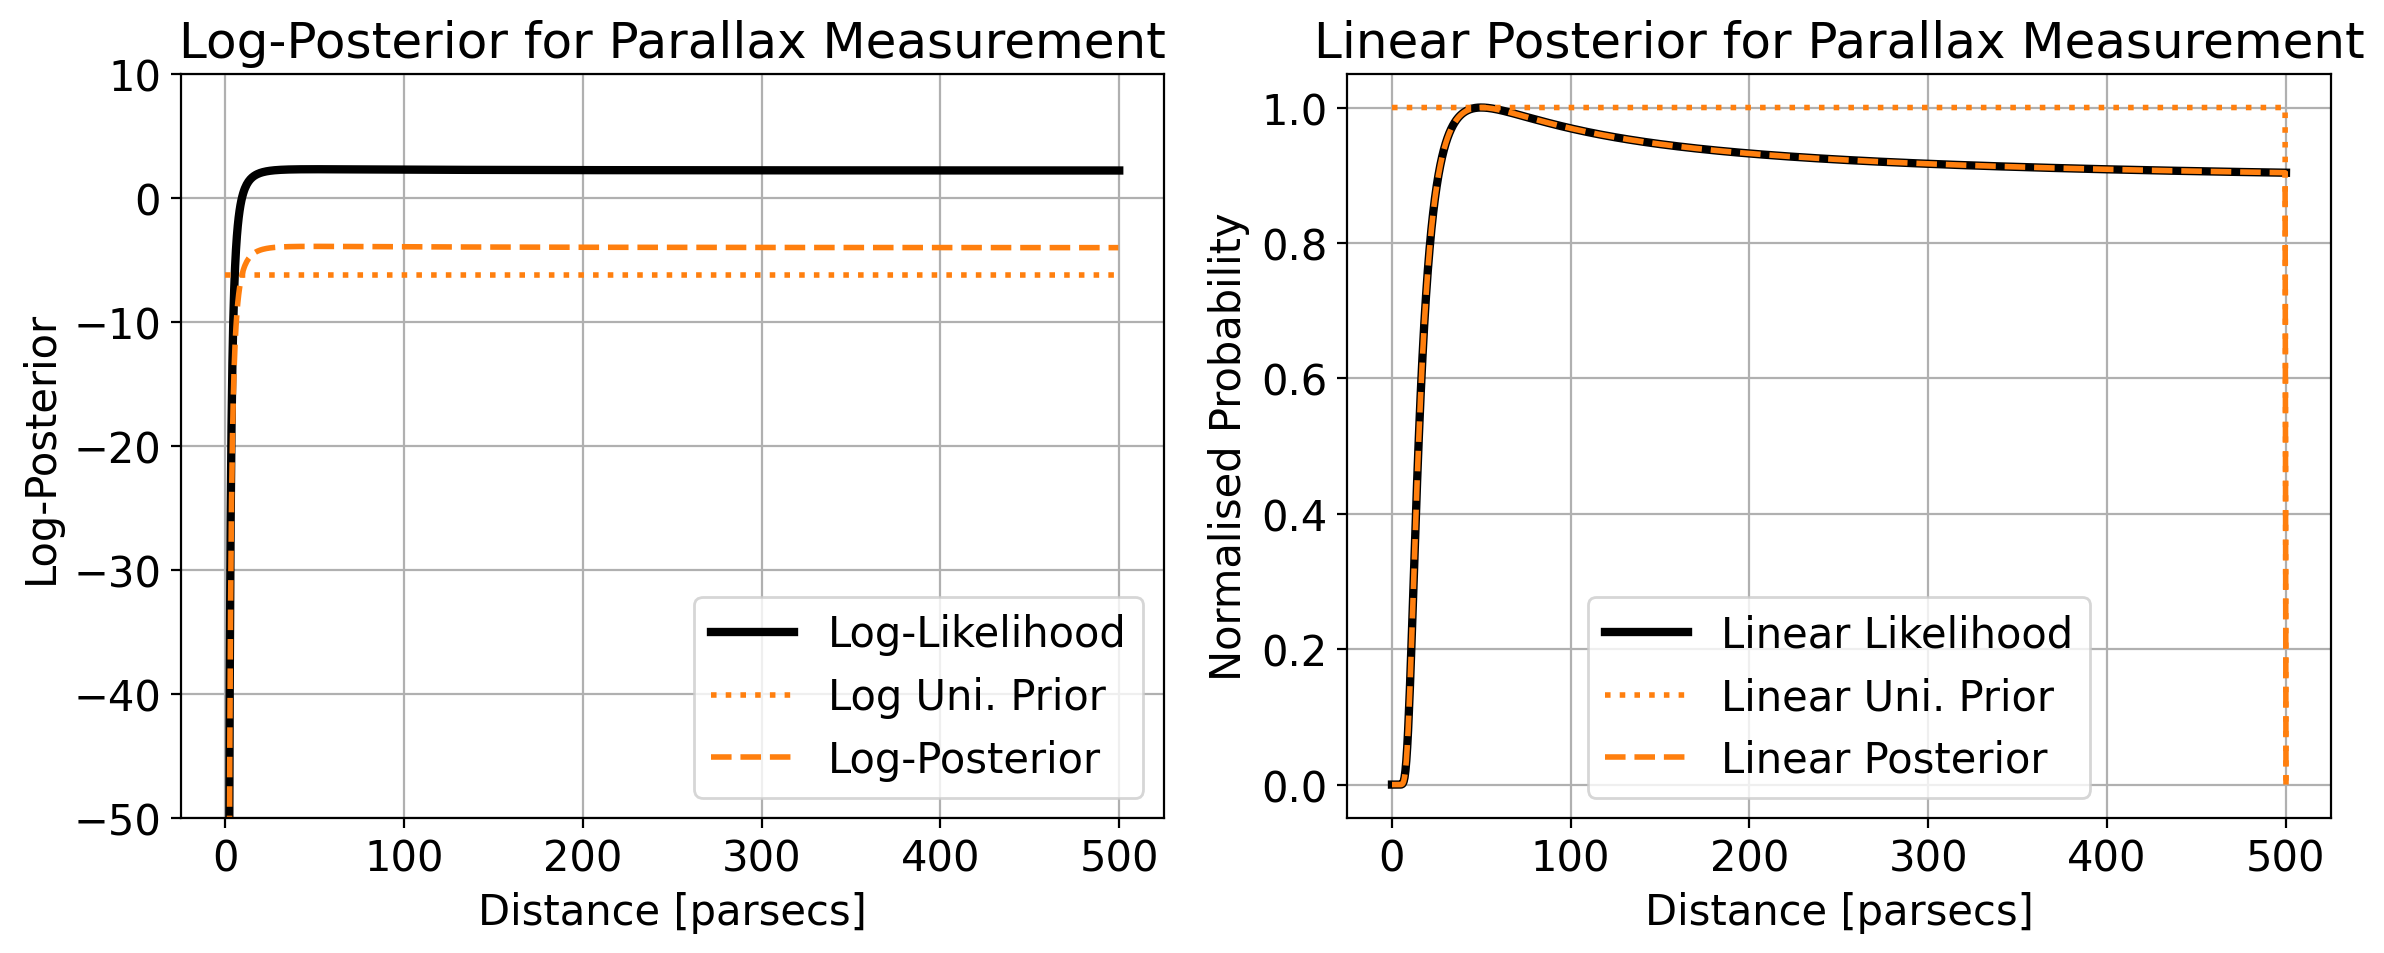

In [20]:
# Create a 2-panel plot for log-posterior and linear posterior
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot log-posterior (left panel)
axs[0].plot(distance_vals, log_likelihood_vals, label="Log-Likelihood", lw=3, c = 'k')
axs[0].plot(distance_vals, log_prior_vals, label="Log Uni. Prior", lw=2, ls = 'dotted', c = 'C1')
axs[0].plot(distance_vals, log_posterior_vals, label="Log-Posterior", lw=2, ls = 'dashed', c='C1')
axs[0].set_xlabel("Distance [parsecs]")
axs[0].set_ylabel("Log-Posterior")
axs[0].set_title("Log-Posterior for Parallax Measurement")
axs[0].set_ylim(-50,10)
axs[0].legend()
axs[0].grid()

# Plot linear posterior (right panel)
axs[1].plot(distance_vals, linear_likelihood_vals/np.max(linear_likelihood_vals), label="Linear Likelihood", lw=3, c = 'k')
axs[1].plot(distance_vals, linear_prior_vals/np.max(linear_prior_vals), label="Linear Uni. Prior", lw=2, ls = 'dotted', c = 'C1')
axs[1].plot(distance_vals, linear_posterior_vals/np.max(linear_posterior_vals), label="Linear Posterior", lw=2, ls = 'dashed', c='C1')
axs[1].set_xlabel("Distance [parsecs]")
axs[1].set_ylabel("Normalised Probability")
axs[1].set_title("Linear Posterior for Parallax Measurement")
axs[1].legend()
axs[1].grid()


# Adjust layout for better viewing
plt.tight_layout()

# Show the plot
plt.show()

## 5.  Different prior

Let's try an exponential prior instead with a specific scale length L:

$$
P(D_\varpi) = \frac{1}{L} \cdot \exp{-\frac{D_\varpi}{L}}
$$

$$
P(D_\varpi=0) = \frac{1}{L}
$$

If we go to $D_\varpi = 5 L$, however, this prior delivers

$$
P(D_\varpi = 5L) = \frac{1}{L} \cdot \exp{-5} = 0.0067 \frac{1}{L}
$$

The ratio of these two values gives the relative probability
$$
\frac{P(D_\varpi = 5L)}{P(D_\varpi=0)} = 0.0067
$$

So at $D_\varpi = 5L$, the probability has dropped to 0.67% of its initial value at $P(D_\varpi=0)$.

In [21]:
# Previous prior for reference
# # Log-Prior function (uniform between 0 and rmax)
# def log_prior(distance, distance_max):
#     """Log-uniform prior for distance (r) truncated between 0 and rmax."""
#     if distance > 0 and distance < distance_max:
#         return -np.log(distance_max)
#     else:
#         return -np.inf  # log(0) for impossible distances
    
# Log-Prior function (exponential prior with scale length L)
def log_prior2(r, L):
    """Log-exponential prior for distance with scale length L."""
    if r > 0:
        return -r / L - np.log(L)  # log of exponential distribution
    else:
        return -np.inf  # log(0) for impossible distances


In [22]:
# Let's recompute the prior and posterior
log_prior2_vals = [log_prior2(distance, L=100) for distance in distance_vals]
log_posterior2_vals = np.array(log_likelihood_vals) + np.array(log_prior2_vals)

linear_prior2_vals = np.exp(log_prior2_vals)
linear_posterior2_vals = np.exp(log_posterior2_vals)

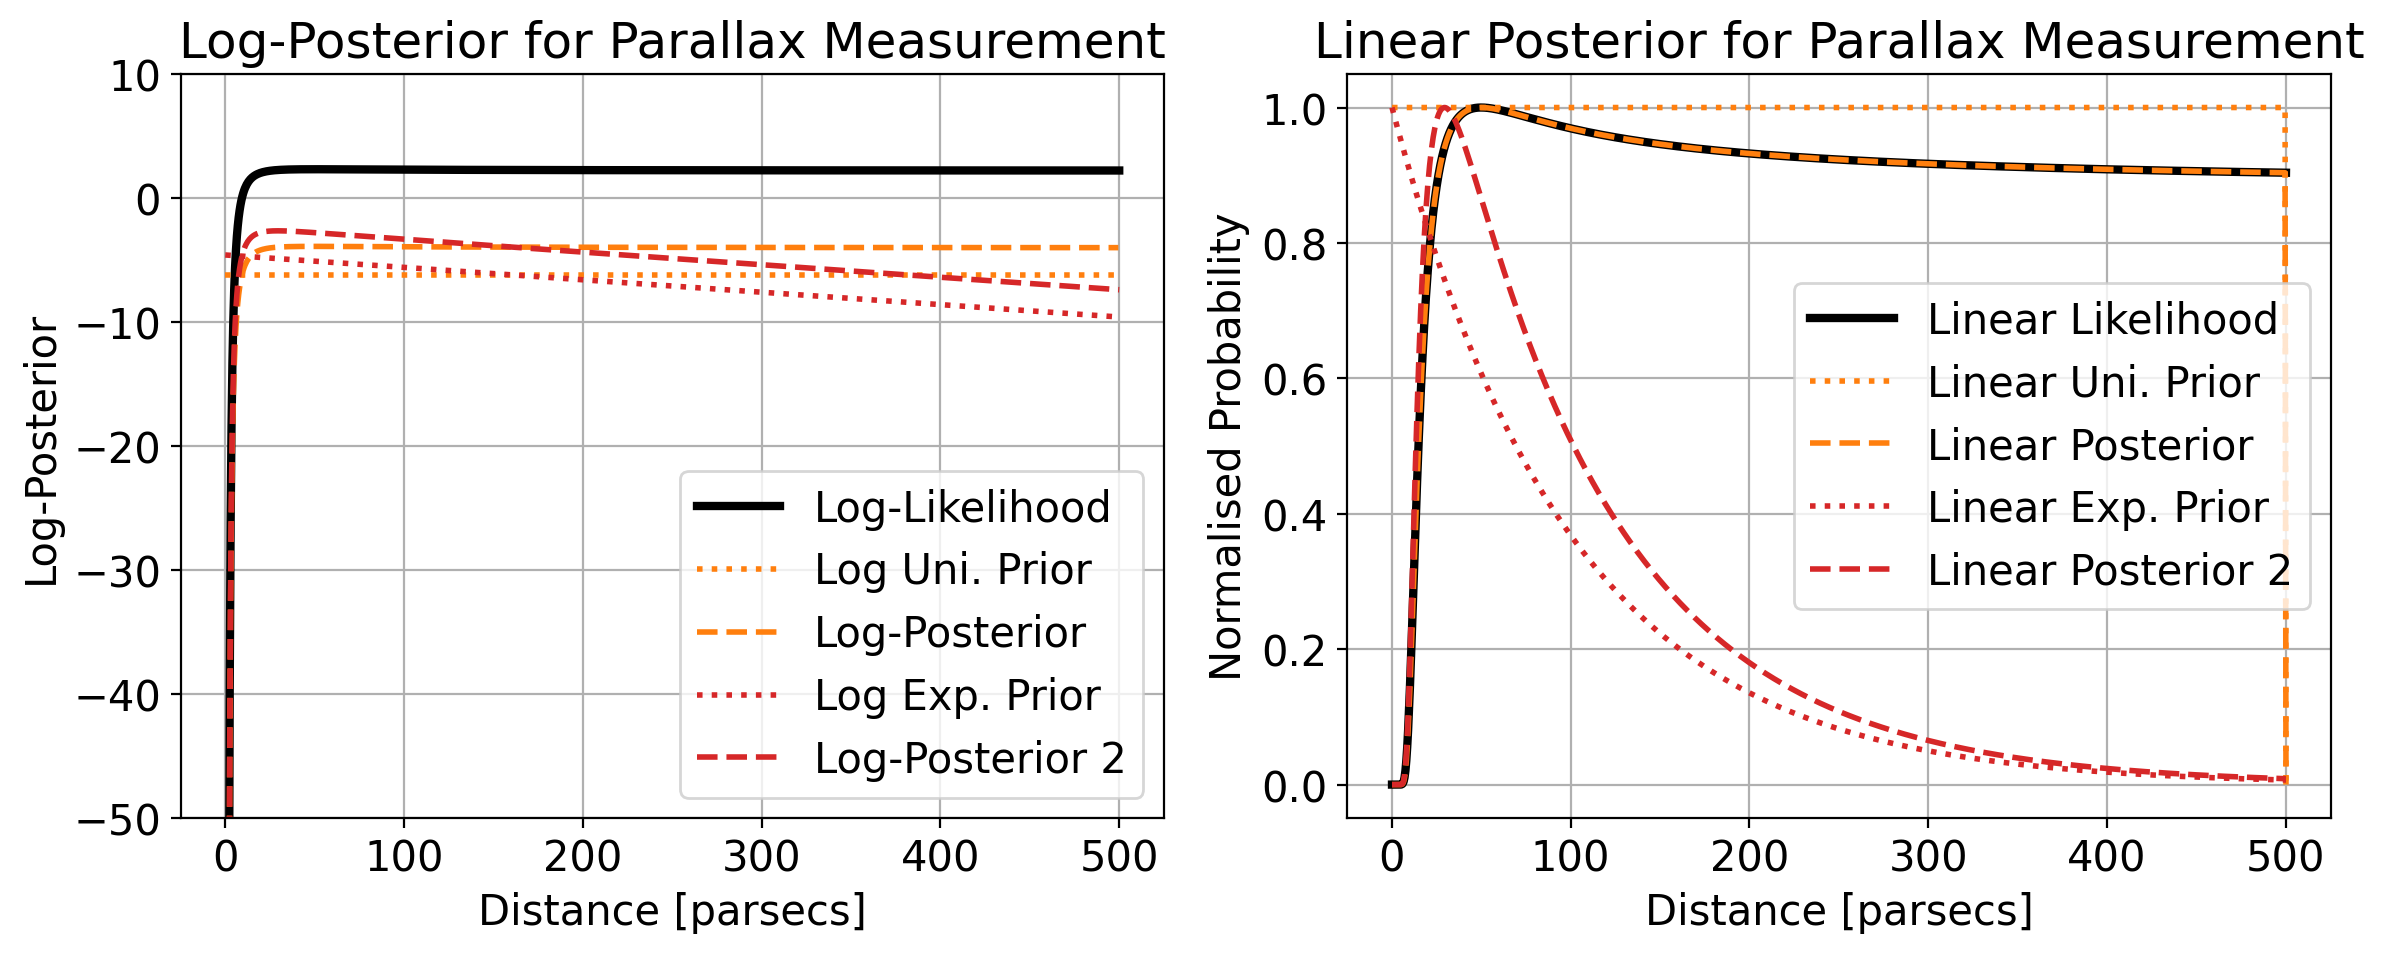

In [23]:
# Create a 2-panel plot for log-posterior and linear posterior
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot log-posterior (left panel)
axs[0].plot(distance_vals, log_likelihood_vals, label="Log-Likelihood", lw=3, c = 'k')
axs[0].plot(distance_vals, log_prior_vals, label="Log Uni. Prior", lw=2, ls = 'dotted', c = 'C1')
axs[0].plot(distance_vals, log_posterior_vals, label="Log-Posterior", lw=2, ls = 'dashed', c='C1')
axs[0].plot(distance_vals, log_prior2_vals, label="Log Exp. Prior", lw=2, ls = 'dotted', c = 'C3')
axs[0].plot(distance_vals, log_posterior2_vals, label="Log-Posterior 2", lw=2,  ls = 'dashed', c = 'C3')
axs[0].set_xlabel("Distance [parsecs]")
axs[0].set_ylabel("Log-Posterior")
axs[0].set_title("Log-Posterior for Parallax Measurement")
axs[0].set_ylim(-50,10)
axs[0].legend()
axs[0].grid()

# Plot linear posterior (right panel)
axs[1].plot(distance_vals, linear_likelihood_vals/np.max(linear_likelihood_vals), label="Linear Likelihood", lw=3, c = 'k')
axs[1].plot(distance_vals, linear_prior_vals/np.max(linear_prior_vals), label="Linear Uni. Prior", lw=2, ls = 'dotted', c = 'C1')
axs[1].plot(distance_vals, linear_posterior_vals/np.max(linear_posterior_vals), label="Linear Posterior", lw=2, ls = 'dashed', c='C1')
axs[1].plot(distance_vals, linear_prior2_vals/np.max(linear_prior2_vals), label="Linear Exp. Prior", lw=2, ls = 'dotted', c = 'C3')
axs[1].plot(distance_vals, linear_posterior2_vals/np.max(linear_posterior2_vals), label="Linear Posterior 2", lw=2,  ls = 'dashed', c = 'C3')
axs[1].set_xlabel("Distance [parsecs]")
axs[1].set_ylabel("Normalised Probability")
axs[1].set_title("Linear Posterior for Parallax Measurement")
axs[1].legend()
axs[1].grid()

# Adjust layout for better viewing
plt.tight_layout()

# Show the plot
plt.show()